<a href="https://colab.research.google.com/github/mehedi-4/neural-net-practice/blob/main/movie_review_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import re
import shutil
import string
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras import layers
from tensorflow.keras import losses

In [7]:
print(tf.__version__)

2.19.0


In [23]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

In [24]:
dataset_dir = os.path.join(dataset, 'aclImdb')
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'test', 'README', 'train']

In [29]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'unsup',
 'urls_pos.txt',
 'unsupBow.feat',
 'pos',
 'labeledBow.feat',
 'urls_neg.txt',
 'neg']

In [30]:
sample_file = os.path.join(train_dir, 'pos/5582_9.txt')
with open(sample_file) as f:
  print(f.read())

In 1930,Europe received quite a shock when Luis Bunuel's 'L'Age Dor' was released, causing a riot in Paris when screened there,resulting in it being banned for something like over forty years. Three years later,in 1933,when Europe had gotten over the shock,it was once again turned on it's ear with 'Ekstase',a symphony (of sorts)to love. The film starred a young,unknown German actress named Hedwig Kiesler,who would later change her name to Hedy Lamarr,when she moved to America to escape the madness of Adolf Hitler,as Eva,a young bride who has just married a cold,distant loveless husband (played by Emil Jerman),only to discover that she has made a major mistake. One divorce later,Eva is footloose & fancy free & is out one day, skinny dipping in a lake,when she discovers Adam,a handsome,young engineer (played by Aribert Mog)who takes a real fancy to her (and she,him). After a wild night of passion,Eva's ex-husband turns up once again,hoping to win Eva back,only to find he now has a rival.

In [31]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [33]:

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=32,
    seed=1,
    subset='training',
    validation_split=0.2
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [39]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(32):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'I did not expect much from this film, but boy-o-boy, I did not expect the movie to be this bad. Chris Rock is not showing a good act here, you can\'t get the feeling that his caracter is real, I think the movie would have been a bit better if it\'s drama or romantic scenes would have been a less part of the movie and more/better humor was involved. The movie is like the film makers were having a bad hangover making it. In the "making of" they don\'t show a single smile. This is a very bad film! I gave it three out of ten because of few smiles it gave me, but I did never laugh!'
Label 0
Review b"This is an OK adaptation, but not as good as the TV version. The actors are generally alright but I found Jeremy Northam rather wet as Mr Knightley, particularly compared to Mark Strong in the TV version. Gwyneth Paltrow is OK and her English accent is pretty good but again, I preferred Kate Beckinsale's Emma. There are excellent support performances from Toni Collette, Juliet Stephenso

In [42]:
raw_train_ds.class_names

['neg', 'pos']

In [43]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=32,
    seed=1,
    subset='validation',
    validation_split=0.2
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [45]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir, 'test'),
    batch_size=32
)

Found 25000 files belonging to 2 classes.


In [46]:
#custom standardizationo

In [47]:
vectorize_layer = layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=10000,
    output_mode='int',
    output_sequence_length=250
)

In [48]:
train_text = raw_train_ds.map(lambda text, labels: text)
vectorize_layer.adapt(train_text)

In [49]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [51]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(1):
    rev = text_batch[i]
    lab = label_batch[i]
    print(rev)
    print(raw_train_ds.class_names[lab])
    print(vectorize_text(rev, lab))

tf.Tensor(b"This is the one in which the diminutive Ruth Gordon plays an Agatha-Christie type of murder mystery author who locks her nephew by marriage into a safe. Gordon believes that he murdered her niece and the young fellow dies of suffocation, while Gordon is traveling back and forth to New York. He manages, however, to leave behind some clues, scratches on a couple of black safe deposit boxes and an improvised and well-hidden note. Columbo enters the case, suspects her at once, and solves the mystery by simply using his supernatural mystical intuitive powers. Oh, and Mariette Hartley is on hand as Gordon's secretary and would-be blackmailer. Hartley is, I believe, the grand daughter of the psychologist B. F. Skinner. I'm not sure her ancestry had anything to do with her attractive belly button, which is on display during a belly dance sequence, but I've always admired Skinner anyway.<br /><br />The murder is well handled. It's a good plot, and none of the performers or crew fluf

In [53]:
print("1287", vectorize_layer.get_vocabulary()[1287])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 dad
Vocabulary size: 10000


In [54]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [55]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [100]:
model = tf.keras.Sequential([
    layers.Embedding(10000, 16),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
    # layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)]
)

In [101]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - binary_accuracy: 0.5953 - loss: 0.6826 - val_binary_accuracy: 0.7312 - val_loss: 0.6160
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.7501 - loss: 0.5842 - val_binary_accuracy: 0.8036 - val_loss: 0.5000
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - binary_accuracy: 0.8174 - loss: 0.4723 - val_binary_accuracy: 0.8338 - val_loss: 0.4275
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8488 - loss: 0.4010 - val_binary_accuracy: 0.8458 - val_loss: 0.3847
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - binary_accuracy: 0.8663 - loss: 0.3540 - val_binary_accuracy: 0.8532 - val_loss: 0.3589
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - binary_accuracy: 0.8767 - loss: 0.3198 - val_binary_accuracy: 0.8586 - val_loss: 0.3419
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - binary_accuracy: 0.8862 - loss: 0.2949 - val_binary_accuracy: 0.8644 - val_loss: 0.3293
Epoch 

In [107]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - binary_accuracy: 0.8661 - loss: 0.3170
Loss:  0.31815066933631897
Accuracy:  0.866919994354248


In [108]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

In [109]:
accuracy = history_dict['binary_accuracy']
val_accuracy = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(accuracy) + 1)

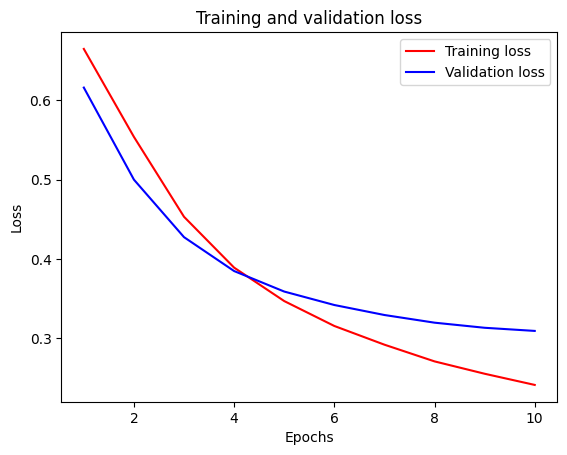

In [110]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

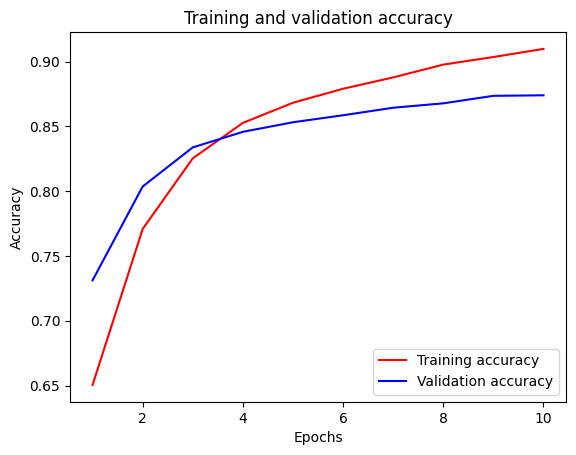

In [111]:
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

Export

In [116]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  # layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [117]:
metrics = export_model.evaluate(raw_test_ds, return_dict=False)


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:789: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8663 - loss: 0.3168


In [118]:
examples = tf.constant([
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
])

export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


array([[0.7283278 ],
       [0.55421984],
       [0.43450764]], dtype=float32)